# Resultados del modelo end-to-end para la predicción de parámetros de distribuciónes de tamaños en señales de Hahn

In [1]:
using Plots
using Flux
using Flux: train!
using DataFrames
using CSV
using DifferentialEquations
using Statistics
using Random
using LinearAlgebra
using SciMLSensitivity
using ComponentArrays, Optimization, OptimizationOptimJL, OptimizationFlux
using OrdinaryDiffEq
using Measures

Carga de datos de señales y parámetros $l_{cm}$ y $\sigma$ de las distribuciones de tamaños subyacentes a las señales de Hahn

In [2]:
rng = Random.seed!(1234)

# Importamos los parámetros del experimento
include("./Parameters.jl")

# Importamos las utilidades para las señales
include("./UtilidadesSeñales.jl")

# Path desde donde se leen los datos de las señales de Hahn
path_read = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/1-GeneracionDatos/Data/SimpleSignalHahn_TE_1_G_8.73e-7.csv"

# Leemos los datos de las señales 
signalsDF = transpose(Matrix(CSV.read(path_read, DataFrame)))

# Obtenemos los parámetros de las señales para identificarlas posteriormente
column_lcm = collect(lcms)
column_sigma = collect(σs)
pdistparamsDF = zeros(size(signalsDF)[2], 2)

for (i, lcm) in enumerate(column_lcm)
    for (j, sigma) in enumerate(column_sigma)
        pdistparamsDF[(i - 1) * length(σs) + j, 1] = sigma
        pdistparamsDF[(i - 1) * length(σs) + j, 2] = lcm
    end
end

pdistparamsDF = DataFrame(pdistparamsDF, [:sigma, :lcm]);

Mezclamos los datos y los dividimos en conjuntos de entrenamiento, validación y prueba

In [3]:
# Mezclamos los datos para que no haya sesgo en el entrenamiento
perm = randperm(rng, size(signalsDF, 2))

signalsDF_shuffled = signalsDF[:, perm]
pdistparamsDF_shuffled = Matrix(pdistparamsDF)[perm, :];

In [4]:
# Split en entrenamiento, validación y test
n_signals = size(signalsDF, 2)
n_train = Int(floor(n_signals*0.7))
n_val = Int(floor(n_signals*0.15))
n_test = n_signals - n_train - n_val

train_signals = Float32.(Matrix(signalsDF_shuffled[:, 1:n_train]))
val_signals = Float32.(Matrix(signalsDF_shuffled[:, n_train+1:n_train+n_val]))
test_signals = Float32.(Matrix(signalsDF_shuffled[:, n_train+n_val+1:end]))

# Output del modelo
train_params = Float32.(Matrix(pdistparamsDF_shuffled[1:n_train, :])[:,end:-1:1]) 
val_params = Float32.(Matrix(pdistparamsDF_shuffled[n_train+1:n_train+n_val, :])[:,end:-1:1])
test_params = Float32.(Matrix(pdistparamsDF_shuffled[n_train+n_val+1:end, :])[:,end:-1:1]);

In [6]:
println("Tamaño de los datos de entrenamiento: ", size(train_signals, 2))
println("Tamaño de los datos de validación: ", size(val_signals, 2))
println("Tamaño de los datos de test: ", size(test_signals, 2))

Tamaño de los datos de entrenamiento: 3919
Tamaño de los datos de validación: 840
Tamaño de los datos de test: 841


* Tomamos los 8 datos de la señal con los que fue entrenada la red ANODE

In [7]:
# Vamos a tomar un subconjunto de t para hacer el entrenamiento de la NODE para agilizar los tiempos de entrenamiento
muestreo_corto = 20 # Cada cuantos tiempos tomamos un timepo para entrenar la NODE
muestreo_largo = 10

# Esto da 60 tiempos 50 puntos desde 0 a 0.1 y 10 puntos desde 0.1 a 1
t_shortaux = t_short[1:muestreo_corto:end]
t_longaux = t_long[1:muestreo_largo:end]

t = vcat(t_shortaux, t_longaux)

indexes_t = [i for i in 1:length(times) if times[i] in t]

# Obtenemos las señales con el dominio de tiempo reducido (Input del modelo)
signalsTrain = transpose(train_signals[indexes_t, :])
signalsVal = transpose(val_signals[indexes_t, :])
signalsTest = transpose(test_signals[indexes_t, :]);

In [8]:
# Numero de puntos para la predicción
n_usados = 8

# Indice final de los tiempos
idx_end = length(t)

# Tomamos 8 de los tiempos que tenemos para la predicción como parámetros extra para la ANODE
n_usados_short = floor(Int, n_usados * 0.9)
n_usados_long = ceil(Int, n_usados * 0.1)

step_short = ceil(Int, 51 / n_usados_short)
step_long = ceil(Int, 9 / n_usados_long)

t_usados = t[1:step_short:51]
t_usados = vcat(t_usados, t[51:step_long:idx_end])

if t_usados[end] != t[end]
    push!(t_usados, t[end])
end

t_usados = unique(t_usados)
indexes_usados = [i for i in 1:length(t) if t[i] in t_usados]

signalsTrainPuntos = signalsTrain[:,indexes_usados]
signalsValPuntos = signalsVal[:,indexes_usados]
signalsTestPuntos = signalsTest[:,indexes_usados]

# Obtenemos las interpolaciones de las señales y de las derivadas
extra_input = signalsTrainPuntos
extra_input_valid = signalsValPuntos
extra_input_test = signalsTestPuntos;

In [9]:
# Todas las señales tienen la misma condición inicial s(0) = 1, vamos a usar una ANODE por lo que necesitamos además las condiciónes iniciales a(0) = 0
U0 = [ones(size(signalsTrain)[1]) zeros(size(signalsTrain)[1])]
U0_valid = [ones(size(signalsVal)[1]) zeros(size(signalsVal)[1])]
U0_test = [ones(size(signalsTest)[1]) zeros(size(signalsTest)[1])];

### Carga de la red ANODE

In [10]:
# Función de activación
activation = relu

# 27 Arquitecura: Any[[12, 32, 32, 16, 2], relu]
extra_dim = size(extra_input, 2)

# Input t, S(t), a(t), extra_input = puntos medidos de la señal
input_size = 1 + 2 + extra_dim

nn = Flux.Chain(Flux.Dense(input_size, 32),
            Flux.Dense(32, 32, activation),
            Flux.Dense(32, 16, activation),
            Flux.Dense(16, 2),
            )
# Output S(t), a(t)

p_anode, re_anode = Flux.destructure(nn)

path_anode = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/PANODE/027_Parameters.csv"
# Leemos los parámetros de la red ya entrenada si es que existen
if isfile(path_anode)
    println("Se encontraron los parámetros de la red neuronal")
    theta_nn = CSV.read(path_anode, DataFrame)
    p_anode = @views Float32.(theta_nn[:,1])
else
    println("No se encontraron los parámetros de la red neuronal")
end

Se encontraron los parámetros de la red neuronal


2034-element Vector{Float32}:
 -0.0011969391
 -0.047141284
  0.0430411
 -0.18170705
 -0.021800833
  0.03808479
 -0.13384674
  0.22744866
 -0.26386517
  0.4408931
  ⋮
 -0.031040445
 -0.812874
  0.8522615
 -0.50337857
  0.80006266
  0.0844056
 -0.2194015
 -0.08247783
  0.20401475

#### Funciones del modelo ANODE

In [11]:
# Tiempo sobre el cual resolver la ODE
tspan = (0f0, 1f0)

# Función que resuelve la ODE con la red neuronal
function SolveANODE(u0, extra, time_batch)
    # Definimos la función que resuelve la ODE
    function dSdt!(u, p, t)
        S = u[1]
        a = u[2]
        entrada = [t, S, a, extra...]
        return re_anode(p)(entrada)
    end

    # Definimos el problema de la ODE
    prob = ODEProblem(dSdt!, u0, tspan)

    # Resolvemos la ODE, devolvemos únicamente la solución S(t)
    solution = @views Array(solve(prob, Tsit5(), p = p_anode, saveat = time_batch, dtmin = 1e-9))[1, :]

    return solution
end

# Función que predice las señales para un conjunto de condiciones iniciales y parámetros extra
function PredictSignals(U0, extra, time_batch)
    predicted_signals = map(1:length(U0[:,1])) do i
        u0 = Float32.(U0[i,:])
        if length(extra) > extra_dim
            SolveANODE(u0, extra[i, :], time_batch)
        else
            SolveANODE(u0, extra[1,:], time_batch)
        end
    end
    
    return @views transpose(reduce(hcat, predicted_signals))
end

PredictSignals (generic function with 1 method)

### Carga de red Autoencoder

In [12]:
# Dimensión de entrada con la que fue entrenado el autoencoder
n_times = size(train_signals, 1)

# Definimos el encoder
encoder = Flux.Chain(Flux.Dense(n_times, 500, bias = false), Flux.Dense(500, 100, relu), Flux.Dense(100, 50, relu), Flux.Dense(50, 3))
decoder = Flux.Chain(Flux.Dense(3, 50, bias = false), Flux.Dense(50, 100, relu), Flux.Dense(100, 500, relu), Flux.Dense(500, n_times))

# Cargamos los parámetros del encoder y decoder
p_encoder, re_encoder = Flux.destructure(encoder)
p_decoder, re_decoder = Flux.destructure(decoder)

# Carga de parámetros del encoder y decoder
path_encoder = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Autoencoder/deeperNLParamsE.csv"
if isfile(path_encoder)
    println("Se encontraron los parámetros del encoder")
    theta_encoder = @views Float32.(CSV.read(path_encoder, DataFrame)[:,1])
    p_encoder = theta_encoder
else
    println("No se encontraron los parámetros del encoder")
end

path_decoder = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Autoencoder/deeperNLParamsD.csv"
if isfile(path_decoder)
    println("Se encontraron los parámetros del decoder")
    theta_decoder = @views Float32.(CSV.read(path_decoder, DataFrame)[:,1])
    p_decoder = theta_decoder
else
    println("No se encontraron los parámetros del decoder")
end

Se encontraron los parámetros del encoder
Se encontraron los parámetros del decoder


606349-element Vector{Float32}:
  0.20035024
  0.08563812
  0.20520326
 -0.05935989
  0.13685593
  0.006845826
 -0.17439996
  0.26555297
  0.1386663
 -0.19019352
  ⋮
 -0.01715766
 -0.019373644
 -0.018957965
 -0.017372835
 -0.0235841
 -0.02221226
 -0.019325605
 -0.02192473
 -0.026908956

#### Funciones del modelo Autoencoder

* Tener una entrada al autoencoder de media 0 mejoró la calidad de la reconstrucción por lo que se hace esto luego de predecir las señales con la ANODE

In [13]:
# En cada columna tenmos los datos de las señales, centramos estas columnas para que tengan media 0
function centerData(matrix)
    """Función que centra los datos de las columnas de una matriz para que tengan media 0
    Parametros
        matrix: matriz con los datos a centrar
    Retorna
        centered_data: matriz con los datos centrados
    """
    col_mean = mean(matrix, dims=2)
    centered_data = matrix .- col_mean
    return Float32.(centered_data), Float32.(col_mean)
end

centerData (generic function with 1 method)

### Carga del modelo Feedforward

In [14]:
# Definimos la red neuronal
model_nn = Flux.Chain(
    Dense(3, 32),
    Dense(32, 64, tanh_fast),
    Dense(64, 32, tanh_fast),
    Dense(32, 16, tanh_fast),
    Dense(16, 2, softplus), # Softplus me asegura que los valores de salida sean positivos
)

# Obtenemos los parámetros de la red neuronal
p_nn, re_nn = Flux.destructure(model_nn)

path_params_nn = "C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/NeuralNetwork/TrainedParams copy.csv"
if isfile(path_params_nn)
    println("Se encontraron los parámetros de la red neuronal")
    theta = CSV.read(path_params_nn, DataFrame)
    p_nn = @views Float32.(theta[:,1])
else
    println("No se encontraron los parámetros de la red neuronal")
end

Se encontraron los parámetros de la red neuronal


4882-element Vector{Float32}:
 -0.25235993
 -0.40522835
  0.41482732
  0.38960344
  0.2916714
  0.11209011
  0.040583804
  0.30154926
 -0.0037222574
 -0.1351432
  ⋮
 -0.34279498
  0.5970705
  0.25688282
  0.78125817
  0.4638926
 -0.7552457
 -0.34863776
  0.155489
 -0.5645213

# Análisis de resultados

In [15]:
function model_end_to_end(U0, extra_parameters)
    # Obtenemos las señales predichas por la NODE
    signals_predicted, signals_mean = centerData(PredictSignals(U0, extra_parameters, times))
    # Obtenemos las componentes reducidas de las señales predichas
    components = re_encoder(p_encoder)(signals_predicted')
    # Obtenemos los parámetros predichos por la red neuronal
    parameters_predicted = re_nn(p_nn)(components)'
    return parameters_predicted, signals_predicted .+ signals_mean
end

model_end_to_end (generic function with 1 method)

### Resultados de los datos de entrenamiento

In [17]:
train_params_predictions, train_signals_predictions = model_end_to_end(U0, extra_input)
val_params_predictions, val_signals_predictions = model_end_to_end(U0_valid, extra_input_valid)
test_params_predictions, test_signals_predictions = model_end_to_end(U0_test, extra_input_test)

(Float32[2.689468 0.33313486; 2.072967 0.4844056; … ; 2.7473958 0.19526435; 2.7462308 0.15739726], Float32[1.0 0.99117845 … -0.013002269 -0.013227589; 1.0 0.9932154 … 0.016624287 0.016403317; … ; 1.0 0.9906455 … -0.012728926 -0.012953963; 1.0 0.990539 … -0.013044249 -0.013274144])

In [19]:
all_params = vcat(train_params, val_params, test_params)
all_predictions = vcat(train_params_predictions, val_params_predictions, test_params_predictions)

5600×2 Matrix{Float32}:
 2.72672   0.119208
 2.16211   0.496971
 2.73723   0.288413
 1.78825   0.586258
 2.69627   0.0774756
 1.74981   0.412372
 1.46867   0.334752
 1.35088   0.463544
 2.63277   0.35926
 2.6936    0.0808579
 ⋮         
 0.967782  0.222017
 2.72515   0.324911
 1.57418   0.633349
 2.70172   0.0856816
 2.35913   0.519914
 2.70008   0.398114
 2.6465    0.386175
 2.7474    0.195264
 2.74623   0.157397

In [20]:
function Pln(lcm, σ)
    return [(exp(-(log(lc) - log(lcm))^2 / (2σ^2))) / (lc * σ * sqrt(2π)) for lc in lcs]
end

Pln (generic function with 1 method)

In [33]:
# Root Mean Squared Error
function RMSE(predicted, real)
    return sqrt(Flux.mse(predicted, real))
end

RMSE_test = RMSE(test_params_predictions, test_params)

N = size(test_params, 1)
RMSE_scores = zeros(N)

for i in 1:N
    RMSE_scores[i] = RMSE(test_params_predictions[i, :], test_params[i, :])
end

In [59]:
# RMSE scores for all predictions

N = size(all_predictions, 1)

RMSE_all = RMSE(all_predictions, all_params)

RMSE_scores_all = zeros(N)

for i in 1:N
    RMSE_scores_all[i] = RMSE(all_predictions[i, :], all_params[i, :])
end

In [29]:
RMSE_all

1.089367f0

In [24]:
lcs = range(0.001, 50, length = 5000)

0.001:0.010001800360072014:50.0

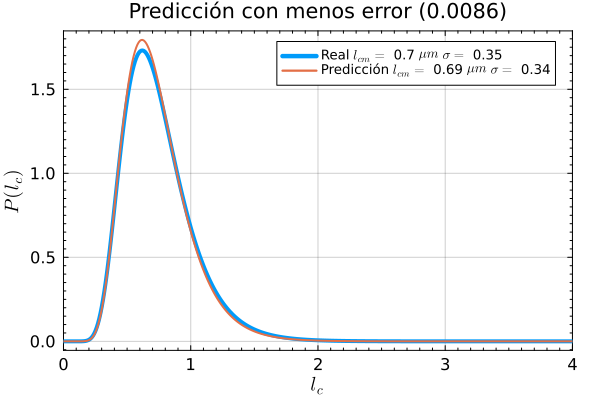

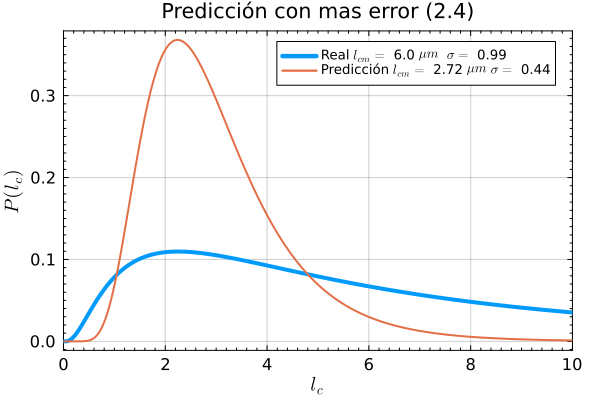

El mínimo RMSE para los datos de test es 0.008642437867820263 y se encuentra en la posición 237
El máximo RMSE para los datos de test es 2.353523015975952 y se encuentra en la posición 541


"C:\\Users\\Propietario\\OneDrive\\Escritorio\\ib\\Tesis_V1\\MLonNMR\\4-IntegracionModelos\\Hahn\\Models\\Plots\\Worst.pdf"

In [57]:
using LaTeXStrings
# Evaluamos la red neuronal con los datos de testeo
best = 0
worst = 0
for i in 1:N
    if minimum(RMSE_scores) == RMSE_scores[i]
        println("El mínimo RMSE para los datos de test es $(RMSE_scores[i]) y se encuentra en la posición $i")
        best = i
    end
    if maximum(RMSE_scores) == RMSE_scores[i]
        println("El máximo RMSE para los datos de test es $(RMSE_scores[i]) y se encuentra en la posición $i")
        worst = i
    end
end

P_real_best = Pln.(test_params[best,1], test_params[best,2])
P_predict_best = Pln.(test_params_predictions[best,1], test_params_predictions[best,2])

P_real_worst = Pln.(test_params[worst,1], test_params[worst,2])
P_predict_worst = Pln.(test_params_predictions[worst,1], test_params_predictions[worst,2])

pl_best = Plots.plot(lcs, P_real_best, label = L"Real $l_{cm} = $" * " $(test_params[best,1]) " * L"$\mu m$" * L" $σ = $" * " $(test_params[best,2])", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 4, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
Plots.plot!(pl_best, lcs, P_predict_best, label = L"Predicción $l_{cm} = $" * " $(round(test_params_predictions[best,1],digits = 2)) " * L"$\mu m$" * L" $σ =$" * " $(round(test_params_predictions[best,2],digits = 2))", title = "Predicción con menos error ($(round(minimum(RMSE_scores),sigdigits = 2)))" , lw = 2, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
xlims!(0, 4)
display(pl_best)

Plots.savefig("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Plots/Best.png")
Plots.savefig("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Plots/Best.pdf")

pl_worst = Plots.plot(lcs, P_real_worst, label = L"Real $l_{cm} = $" * " $(test_params[worst,1]) " * L"$\mu m$ " * L" $σ = $" * " $(test_params[worst,2])", title = "Predicción con mas error ($(round(maximum(RMSE_scores),sigdigits = 2)))" , xlabel = L"l_c", ylabel = L"P(l_c)", lw = 4, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
Plots.plot!(pl_worst, lcs, P_predict_worst, label = L"Predicción $l_{cm} = $" * " $(round(test_params_predictions[worst,1],digits = 2)) " * L"$\mu m$" * L" $σ = $" * " $(round(test_params_predictions[worst,2],digits = 2))", xlabel = L"l_c", ylabel = L"P(l_c)", lw = 2, legend=:best, tickfontsize=11, labelfontsize=13, legendfontsize=9, framestyle =:box, gridlinewidth=1, xminorticks=10, yminorticks=10, right_margin=5mm)
xlims!(0, 10)
display(pl_worst)

Plots.savefig("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Plots/Worst.png")
Plots.savefig("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Plots/Worst.pdf")


# # Merge the graps in a single plot
# pl = plot(pl_best, pl_worst, layout = (1, 2), size = (1200, 400))

# display(pl)

# # Save the plot
# Plots.savefig("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Plots/BestWorst.png")
# Plots.savefig("C:/Users/Propietario/OneDrive/Escritorio/ib/Tesis_V1/MLonNMR/4-IntegracionModelos/Hahn/Models/Plots/BestWorst.pdf")

In [35]:
println("RMSE para los datos de testeo: ", RMSE_test)

RMSE para los datos de testeo: 1.1073675


In [36]:
all_params

5600×2 Matrix{Float32}:
 5.0  0.4
 2.9  0.73
 4.6  0.58
 2.3  0.88
 5.3  0.05
 2.1  0.58
 1.6  0.4
 1.5  0.64
 3.1  0.43
 5.9  0.34
 ⋮    
 1.0  0.12
 5.2  0.71
 1.9  0.89
 3.3  0.1
 3.6  0.85
 5.3  0.84
 4.0  0.64
 6.0  0.6
 3.1  0.18

In [38]:
using PlotlyJS

┌ Warning: It looks like the Kaleido process is not responding. 
│ The unresponsive process will be killed, but this means that you will not be able to save figures using `savefig`.
│ 
│ If you are on Windows this might be caused by known problems with Kaleido v0.2 on Windows (you are using version 0.2.1).
│ You might want to try forcing a downgrade of the Kaleido_jll library to 0.1.
│ Check the Package Readme at https://github.com/JuliaPlots/PlotlyKaleido.jl/tree/main#windows-note for more details.
│ 
│ If you think this is not your case, you might try using a longer timeout to check if the process is not responding (defaults to 10 seconds) by passing the desired value in seconds using the `timeout` kwarg when calling `PlotlyKaleido.start` or `PlotlyKaleido.restart`
└ @ PlotlyKaleido C:\Users\Propietario\.julia\packages\PlotlyKaleido\uMRVG\src\PlotlyKaleido.jl:24


In [60]:
# Plots de los errores de la predicion de la red
params_error = PlotlyJS.scatter(
    x = all_params[1:end,1],
    y = all_params[1:end,2],
    mode = "markers",
    hoverinfo = "text",
    hovertext = RMSE_scores_all[1:end],
    marker = attr(
        color = RMSE_scores_all[1:end],  # Use the color_vector for color mapping
        colorscale = "Hot",  # Choose a predefined colormap (e.g., "Viridis")
        colorbar_title = "RMSE",
    ),
)

params_layout = Layout(
    title = "Todos los datos",
    xaxis = attr(title = "lcm"),
    yaxis = attr(title = "σ"),
    font = attr(size = 15),
    width = 800,  # Set width (e.g., 600 pixels)
    height = 600, # Set height equal to width for a square plot
)

layout with fields font, height, margin, template, title, width, xaxis, and yaxis


In [61]:
params_plot = PlotlyJS.plot([params_error], params_layout)

┌ Warning: It looks like the Kaleido process is not responding. 
│ The unresponsive process will be killed, but this means that you will not be able to save figures using `savefig`.
│ 
│ If you are on Windows this might be caused by known problems with Kaleido v0.2 on Windows (you are using version 0.2.1).
│ You might want to try forcing a downgrade of the Kaleido_jll library to 0.1.
│ Check the Package Readme at https://github.com/JuliaPlots/PlotlyKaleido.jl/tree/main#windows-note for more details.
│ 
│ If you think this is not your case, you might try using a longer timeout to check if the process is not responding (defaults to 10 seconds) by passing the desired value in seconds using the `timeout` kwarg when calling `PlotlyKaleido.start` or `PlotlyKaleido.restart`
└ @ PlotlyKaleido C:\Users\Propietario\.julia\packages\PlotlyKaleido\uMRVG\src\PlotlyKaleido.jl:24
┌ Warning: It looks like the Kaleido process is not responding. 
│ The unresponsive process will be killed, but this means 

data: [
  "scatter with fields hoverinfo, hovertext, marker, mode, type, x, and y"
]

layout: "layout with fields font, height, margin, template, title, width, xaxis, and yaxis"

#### Chequeo
* Se hace con los datos cargados y la entrada original de cada uno de los datos con los que fueron entrenados los modelos

In [ ]:
plot(times, test_signals[:, 5], label = "Real", color = "blue")
plot!(times, test_signals_predictions[5, :], label = "Predicción", color = "red", linestyle = :dash)
xlabel!("Tiempo (s)")
ylabel!("Señal")
title!("Señal Real vs Predicción")

In [ ]:
# Autoencoder
test_signals_C, mean_test_signals = centerData(test_signals')
test_encoded_signals = re_encoder(p_encoder)(test_signals_C')
test_signals_reconstruct = re_decoder(p_decoder)(re_encoder(p_encoder)(test_signals_C')) .+ transpose(mean_test_signals)

plot(times, test_signals[:, 5], label = "Real", color = "blue")
plot!(times, test_signals_reconstruct[:, 5], label = "Reconstrucción", color = "red", linestyle = :dash)
xlabel!("Tiempo (s)")
ylabel!("Señal")
title!("Señal Real vs Reconstrucción Autoencoder")

#### Chequeo ETE con única señal

In [ ]:
test_signal = test_signals[:, 1]
test_params = test_params[:, 1]

In [ ]:
U0_ete = [1 0]
# Obtenemos las señales predichas por la NODE
signal_anode_test = PredictSignals(U0_ete, extra_input, times)

In [ ]:
signal_anode_test_C, mean_anode_signal = centerData(signal_anode_test)

In [ ]:
encoded_signal = re_encoder(p_encoder)(signal_anode_test_C')

In [ ]:
params_predicted_anode = re_nn(p_nn)(encoded_signal)